# Data Exploration

## Install Dependencies

In [1]:
%pip install numpy
%pip install pandas
%pip install geopandas
%pip install 'SQLAlchemy==1.4.46'
%pip install urllib
%pip install zipfile

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
No

## Import Packages

In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
from sqlalchemy import create_engine

## Load Data

In [74]:
con = create_engine('sqlite:///../data/data.sqlite')
df1 = pd.read_sql_table('over_time', con, index_col='Year')
df2 = pd.read_sql_table('by_states', con, index_col='State')

## Data Exploration

### Dataframe 1 - Over Time

In [75]:
df1.head()

,NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,Increase SCP,Increase FCP,Increase CP
Year,,,,,,,,,
2022,2651357,470559,362093,50821,8839,59660,18391,4300,22691
2021,2622132,355961,325449,36723,6005,42728,14098,2834,16932
2020,2917678,194163,200469,26241,3861,30102,10482,2144,12626
2019,3607258,63281,45348,16737,2461,19198,9504,1400,10904
2018,3435778,36062,31442,9421,1340,10761,7316,1121,8437


We add two new columns to the dataframe to be able to better compare the different years
1. `Percentage Full-Electric` which is the percentage of new registrations of cars which drive fully electirc
2. `Percentage Plug-in-Hybrid` which is the percentage of new registrations of cars which are Plug-in-Hybrids

In [81]:
# Add columns for percentage of Electric and Plug-in-Hybrid New registrations
df1['Percentage Full-Electric'] = df1['NR Electric'] / df1['NR Overall']
df1['Percentage Plug-in-Hybrid'] = df1['NR Plug-in-Hybrid'] / df1['NR Overall']

To get a feeling for the correlation between the amount of charging points and the new registrations of electric powered cars, we combine both features in one plot. <br>
For this we plot the percentage share of new registrations in each year as bars and the amount of charging points at the start of the year as a line.

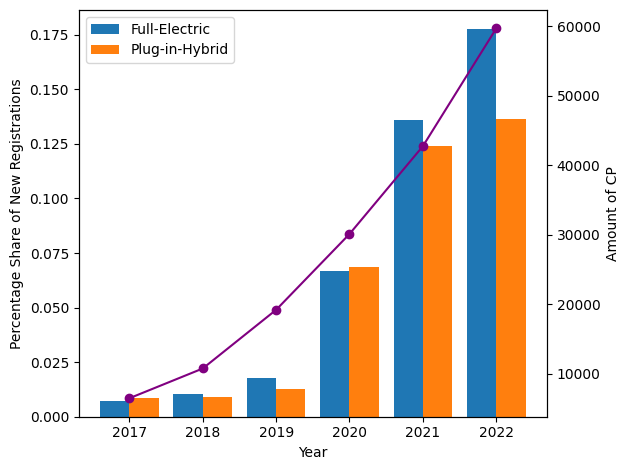

In [108]:
# Sort ascending by the years to get the plot right
df1.sort_index(ascending=True, inplace=True)
X = df1.index
X_axis = np.arange(len(X))


fig, ax1 = plt.subplots()

ax1.bar(X_axis-0.2, df1['Percentage Full-Electric'], 0.4)
ax1.bar(X_axis+0.2, df1['Percentage Plug-in-Hybrid'], 0.4)
ax1.legend(['Full-Electric', 'Plug-in-Hybrid'])
ax1.set_ylabel('Percentage Share of New Registrations')
ax1.set_xlabel('Year')
plt.xticks(X_axis, X)

ax2 = ax1.twinx()

ax2.plot(X_axis, df1['Amount CP'], 'o-', color='purple')
ax2.set_ylabel('Amount of CP')

fig.tight_layout()
plt.show()

In a second plot we show the summed amount of new registrations of cars which are electric powered (either fully electric or via plug-in-hybrid) in relation to the amount of charging points.

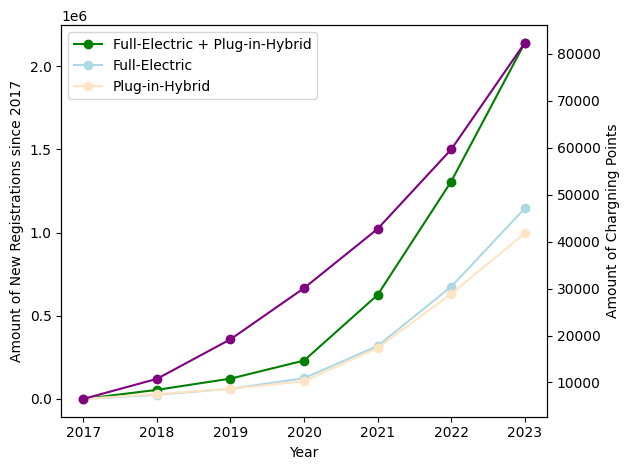

In [126]:
d = df1
d.loc[2023, 'Amount CP'] = d.loc[2022, 'Amount CP'] + d.loc[2022, 'Increase CP']
d['Sum Electric'] = d['NR Electric'].cumsum().shift(1).replace(np.NAN, 0)
d['Sum Plug-in-Hybrid'] = d['NR Plug-in-Hybrid'].cumsum().shift(1).replace(np.NAN, 0)

X = d.index
fig, ax1 = plt.subplots()

ax1.plot(X, d['Sum Electric']+d['Sum Plug-in-Hybrid'], 'o-', color='green')
ax1.plot(X, d['Sum Electric'], 'o-', color='lightblue')
ax1.plot(X, d['Sum Plug-in-Hybrid'], 'o-', color='bisque')
ax1.legend(['Full-Electric + Plug-in-Hybrid', 'Full-Electric', 'Plug-in-Hybrid'])
ax1.set_ylabel('Amount of New Registrations since 2017')
ax1.set_xlabel('Year')

ax2 = ax1.twinx()

ax2.plot(X, df1['Amount CP'], 'o-', color='purple')
ax2.set_ylabel('Amount of Chargning Points')

fig.tight_layout()
plt.show()

### Dataframe 2 - By States

In [69]:
df2.head()

,Abbreviation,Area (km^2),NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,CP per km^2,Percentage Electric
State,,,,,,,,,,
Sachsen-Anhalt,ST,20464.04,43914,5560,4569,801,265,1066,0.052091,0.230655
Sachsen,SN,18449.89,85823,10663,9480,1969,394,2363,0.128077,0.234704
Hamburg,HH,755.09,84411,9149,10976,1422,197,1619,2.144115,0.238417
Mecklenburg-Vorpommern,MV,23294.90,27668,3883,2785,599,151,750,0.032196,0.241000
Thüringen,TH,16202.39,47606,6525,5456,909,311,1220,0.075298,0.251670


To visualize the distribution of new registrations in the different states we use a normalized stacked bar chart 

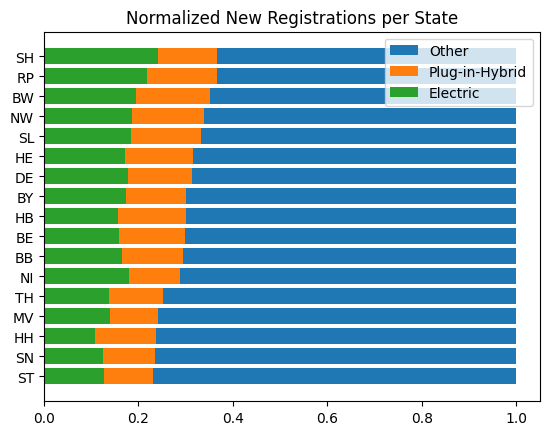

In [67]:
df2.sort_values('Percentage Electric', inplace=True)
plt.barh(df2['Abbreviation'], df2['NR Overall']/df2['NR Overall'])
plt.barh(df2['Abbreviation'], (df2['NR Plug-in-Hybrid']+df2['NR Electric'])/df2['NR Overall'])
plt.barh(df2['Abbreviation'], df2['NR Electric']/df2['NR Overall'])
plt.legend(['Other', 'Plug-in-Hybrid', 'Electric'])
plt.title('Normalized New Registrations per State')
plt.show()

We add two new columns to the dataframe to be able to better compare the different states
1. `CP per km^2` which is the amount of charging points dived trough the area of the state
2. `Percentage Electric` which is the percentage of new registrations of cars which need charging points (electric + plug-in-hybrid)

In [44]:
df2['CP per km^2'] = df2['Amount CP'] / df2['Area (km^2)']
df2['Percentage Electric'] = (df2['NR Plug-in-Hybrid'] + df2['NR Electric']) / df2['NR Overall']
df2.head()

,Abbreviation,Area (km^2),NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,CP per km^2,Percentage Electric
State,,,,,,,,,,
Baden-Württemberg,BW,35747.85,367051,71328,57578,8537,1433,9970,0.278898,0.351194
Bayern,BY,70541.58,549542,95766,70099,10922,1624,12546,0.177853,0.301824
Berlin,BE,891.12,66204,10479,9344,1778,234,2012,2.257833,0.299423
Brandenburg,BB,29654.37,49331,8164,6346,1099,221,1320,0.044513,0.294136
Bremen,HB,419.37,15665,2459,2258,350,48,398,0.949043,0.301117


To get an Overview over the new values we display them on a map of Germany. <br>
For this I use GeoPandas and a shapes dataset with the german states from http://www.diva-gis.org/datadown. <br>
Download Link: https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip

In [39]:
# Download the needed file if not already existing
if not  os.path.exists('./DEU_adm/'):
    import urllib.request
    import zipfile
    urllib.request.urlretrieve('https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip', 'DEU_adm.zip')
    with zipfile.ZipFile('DEU_adm.zip', 'r') as zip_ref:
        zip_ref.extractall('DEU_adm')
    os.remove('DEU_adm.zip')

In [40]:
# Create the dataframe and add the columns to investigate
df_ger = gpd.read_file('./DEU_adm/DEU_adm1.shp') 
df_ger = df_ger.set_index('NAME_1')
df_ger['Percentage Electric'] = df2['Percentage Electric']
df_ger['CP per km^2']  = df2['CP per km^2'] 

First we take a loot at the New Registrations of Electric Powered Cars (Full Electric + Plug-in-Hybrid)

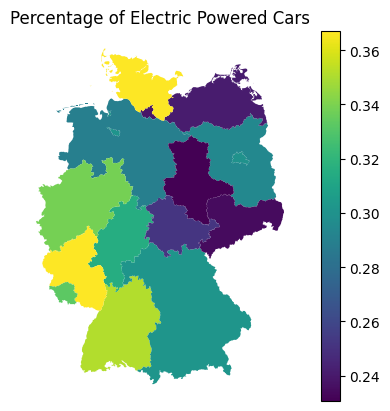

In [32]:
df_ger.plot(column='Percentage Electric', kind='geo', legend=True)
plt.axis('off')
plt.title('Percentage of Electric Powered Cars')
plt.show()

Then on the Amount of Charging Points per Square-Kilometer

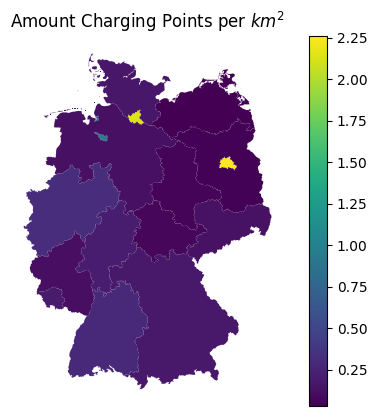

In [33]:
df_ger.plot(column='CP per km^2', kind='geo', legend=True)
plt.axis('off')
plt.title('Amount Charging Points per $km^2$')
plt.show()

As you notice, the states 'Bremen', 'Hamburg' and 'Berlin' stand out extremely from the other states. The reason for this that they are "Stadtstaaten", which means they are more like citys, what causes the much higher rate of CP per $km^2$. <br>
For this reason, we drop these states for the rest of the exploration.

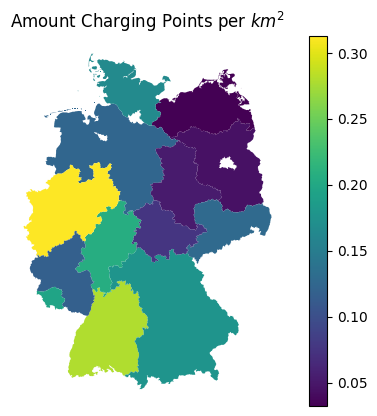

In [34]:
df2.drop(index=['Bremen', 'Berlin', 'Hamburg'], inplace=True)
df_ger.drop(index=['Bremen', 'Berlin', 'Hamburg'], inplace=True)
df_ger.plot(column='CP per km^2', kind='geo', legend=True)
plt.axis('off')
plt.title('Amount Charging Points per $km^2$')
plt.show()

To look for a correlation between the percentage of electric powered cars and the amount of cp per $km^2$ we visualize the states in a scatter plot and try to fit a line

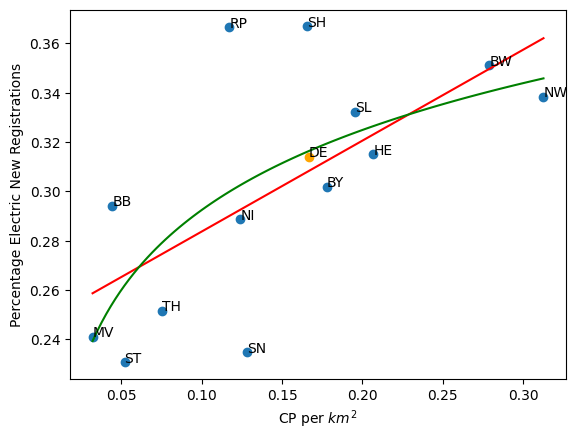

In [35]:
d = df2.drop(index=['Germany'])
x = d['CP per km^2']
y = d['Percentage Electric']
plt.scatter(x, y)
plt.xlabel('CP per $km^2$')
plt.ylabel('Percentage Electric New Registrations')

ger_x = df2.loc['Germany', 'CP per km^2']
ger_y = df2.loc['Germany', 'Percentage Electric']
plt.scatter(ger_x, ger_y, c='orange')
plt.text(ger_x, ger_y, 'DE',)

# Fit a linear function
a, b = polyfit(x, y, 1)
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = b * x_fitted + a
plt.plot(x_fitted, y_fitted, 'r')

# Fit a logarithmic function
t = np.log(x)
a, b = np.polyfit(t, y, 1)
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.log(x_fitted) + b
plt.plot(x_fitted, y_fitted, 'g')

for state in d.index:
    ds = df2.loc[state]
    plt.text(ds['CP per km^2'], ds['Percentage Electric'], ds['Abbreviation'])

plt.show()